In [2]:
import requests
import pandas as pd
import bs4
import re
import matplotlib.pyplot as plt
import os
import glob
from datetime import datetime

The below block takes Bitcoin CSV return data and calculates its returns alone.

In [4]:
bitcoin = pd.read_csv("C:\\Qilin\\Python\\CryptoReturnsModelling\\btc-usd-max.csv")
bitcoin.index = pd.to_datetime(bitcoin['snapped_at'])
del bitcoin['snapped_at']
bitcoin['Returns'] = bitcoin['price'].pct_change().cumsum().fillna(0).multiply(100)
bitcoin.head()

,price,market_cap,total_volume,Returns
snapped_at,,,,
2013-04-28 00:00:00+00:00,135.30,1.500518e+09,0.0,0.000000
2013-04-29 00:00:00+00:00,141.96,1.575032e+09,0.0,4.922395
2013-04-30 00:00:00+00:00,135.30,1.501657e+09,0.0,0.230932
2013-05-01 00:00:00+00:00,117.00,1.298952e+09,0.0,-13.294567
2013-05-02 00:00:00+00:00,103.43,1.148668e+09,0.0,-24.892857


The block below is not currently functional. If done correctly it should take data directly from the coingecko website and calculate returns and aggregate them for every single coin from the first page of the site.

In [62]:
url1 = "https://www.coingecko.com"
r = requests.get(url1)
soup = bs4.BeautifulSoup(r.text, 'lxml')
table = soup.find('table', {'class':'sort table mb-0 text-sm text-lg-normal table-scrollable'})
allLinks = {}
for link in table.find_all('a', {'class': 'tw-hidden lg:tw-flex font-bold tw-items-center tw-justify-between'}, href=True):
    coin = link['href'].split('/')[3]
    allLinks[coin] = link['href']

    
coinlist = []
coinlist_names = []


for k, v in allLinks.items():
    r = requests.get(url1 + allLinks[k])
    soup = bs4.BeautifulSoup(r.text, 'lxml')
    dwnld = soup.find('a', {'class': 'dropdown-item'}, href=True)
    if (dwnld.text == "CSV"):
        urlCSV = url1 + dwnld['href']
        tempdf = pd.read_csv(urlCSV);
        
        tempdf.index = pd.to_datetime(tempdf['snapped_at'])
        tempdf.reindex(bitcoin.index)
        del tempdf['snapped_at']
        del tempdf['market_cap']
        del tempdf['total_volume']
        coinprice = coin + "-price"
        tempdf.rename(columns={"price": coinprice}, inplace=True)
        tempdf[coin + '-returns'] = tempdf[coinprice].pct_change().cumsum().fillna(0).multiply(100)
        coinlist_names.append(coin + '-returns')
        coinlist.append(tempdf)
final_df = pd.concat(coinlist, axis=1)
final_df['avgReturns'] = final_df[coinlist_names].mean(axis=1)

ValueError: No objects to concatenate

Below is a test of webscraping from coingecko. It does not work on Hopkins wifi, but will on eduroam.

In [8]:
now = datetime.now()
end_date = now.strftime("%Y-%m-%d")
print(end_date)

url = "https://www.coingecko.com/en/coins/bitcoin/historical_data/usd?start_date=2013-01-02&end_date="+end_date+"#panel"
r = requests.get(url)
soup = bs4.BeautifulSoup(r.text, 'lxml')
table = soup.find('table', {'class':'table table-striped text-sm text-lg-normal'})
body = table.find_all('tr')
head = body[0]
body_rows = body[1:]

headings = []
for item in head.find_all("th"):
    item = (item.text).rstrip('\n')
    headings.append(item)

print(headings)
rows = []
for i in range(len(body_rows)):
    minirow = []
    for date in body_rows[i].find_all('th'):
        cleaned = re.sub("((\xa0)|(\n)|,|$)","",date.text)
        minirow.append(cleaned)
    for item in body_rows[i].find_all('td'):
        cleaned = re.sub("(\xa0)|(\n)|,|$","",item.text)
        minirow.append(cleaned)
    rows.append(minirow)
    
df = pd.DataFrame(data=rows, columns=headings)
df.index = pd.to_datetime(df['Date'])
del df['Date']
df.head()

2022-02-23
['Date', 'Market Cap', 'Volume', 'Open', 'Close']


,Market Cap,Volume,Open,Close
Date,,,,
2022-02-21,$730381814665,$15998424231,$38514,N/A
2022-02-20,$761447243940,$11735183838,$40193,$38514
2022-02-19,$759881874201,$20130002755,$40073,$40193
2022-02-18,$770096677779,$22270664615,$40563,$40073
2022-02-17,$836256083784,$16847003857,$44063,$40563


The 2 blocks below take CSV files downloaded onto my laptop and works with the data from the top 15 coins currently. The returns suggest that investing in the top 15 as a basket would have produced greater returns since the inception of Bitcoin than investing in Bitcoin alone. The returns are calculated by evenly averaging the returns of each coin each day. This may not be the best method as the price amounts for each coin are very different, so it may be better to split a position among coins based on their dollar amount, and then calculate returns.

In [47]:
path = r'C:\Qilin\Python\CryptoReturnsModelling'
all_files = glob.glob(os.path.join(path + "/*.csv"))

coinlist = []
coinlist_names = []

for filename in os.listdir(path):
    if filename.endswith('.csv'):
        rip = filename.split('-')
        coin = rip[0] + '-' + rip[1]
        
        f = os.path.join(path, filename)
        tempdf = pd.read_csv(f)
        tempdf.index = pd.to_datetime(tempdf['snapped_at'])
        tempdf.reindex(bitcoin.index)
        del tempdf['snapped_at']
        del tempdf['market_cap']
        del tempdf['total_volume']
        coinprice = coin + "-price"
        tempdf.rename(columns={"price": coinprice}, inplace=True)
        tempdf[coin + '-returns'] = tempdf[coinprice].pct_change().cumsum().fillna(0).multiply(100)
        coinlist_names.append(coin + '-returns')
        coinlist.append(tempdf)
final_df = pd.concat(coinlist, axis=1)
final_df['avgReturns'] = final_df[coinlist_names].mean(axis=1)

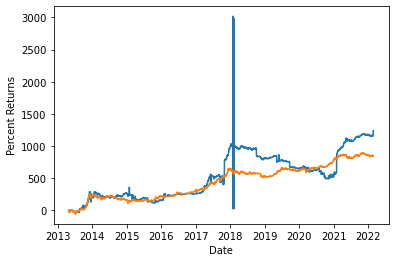

In [46]:
plt.plot(final_df['avgReturns'])
plt.plot(bitcoin['Returns'])
plt.xlabel("Date")
plt.ylabel("Percent Returns")
plt.show()